
# PTSD Model Inference with IRT Features

## [Center for Health Statistics](http://www.healthstats.org)

## [The Zero Knowledge Discovery Lab](http://zed.uchicago.edu)
---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load

%matplotlib inline

In [2]:
datafile='../data/CAD-PTSDData.csv'

In [9]:
def processDATA(datafile):
    '''
        process data file 
        into training data X, target labels y
    '''
    Df=pd.read_csv(datafile)
    X=Df.drop(['record_id','PTSDDx'],axis=1).values
    y=Df.drop(['record_id'],axis=1).PTSDDx.values
    [nsamples,nfeatures]=X.shape
    return X,y,nfeatures,nsamples

In [10]:
def pickleModel(models,threshold=0.87,filename='model.pkl',verbose=True):
    '''
        save trained model set
    '''
    MODELS=[]
    for key,mds in models.items():
        if key >= threshold:
            mds_=[i[0] for i in mds]
            MODELS.extend(mds_)
    if verbose:
        print("number of models (tests):", len(MODELS))
        FS=getCoverage(MODELS,verbose=True)
        print("Item Use Fraction:", FS.size/(len(MODELS)+0.0))
    dump(MODELS, filename)
    return

def loadModel(filename):
    '''
        load models
    '''
    return load(filename)

def drawTrees(model,index=0):
    '''
        draw the estimators (trees)
        in a single model
    '''
    N=len(model[index].estimators_)

    for count in range(N):
        estimator = model[index].estimators_[count]

        export_graphviz(estimator, out_file='tree.dot', 
                        #feature_names = iris.feature_names,
                        #class_names = iris.target_names,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)

        from subprocess import call
        call(['dot', '-Tpng', 'tree.dot', '-o', 'tree'+str(count)+'.png', '-Gdpi=600'])
        from IPython.display import Image
        Image(filename = 'tree'+str(count)+'.png') 

def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS

#test model
def getModel(P,THRESHOLD=0.9):
    '''
        Select only models with minimum AUC
    '''
    Pgood=[model for (auc,model) in zip(P[::2],P[1::2]) if auc > THRESHOLD]
    AUC=[]
    if len(Pgood)==0:
        return Pgood,len(Pgood),0,0,0,[]
    for i in tqdm(range(1000)):
        random_choice=random.randint(0,len(Pgood)-1)
        clf=Pgood[random_choice][0]
        # pretend as if we have not sen any of this data before
        # but we have!
        # need to only use test data here
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        AUC=np.append(AUC,auc)
    DEPTH=Pgood[0][0].max_depth
    N_ESTIMATORS=Pgood[0][0].n_estimators
    
    NITEMS=DEPTH*N_ESTIMATORS
    VARIATIONS=len(Pgood)#2*DEPTH*len(Pgood)
    return Pgood,len(Pgood),np.median(AUC),NITEMS,VARIATIONS,AUC

def getSystem(X,y,max_depth=2,n_estimators=3):
    '''
        get model set with training data X and target labels y
        -> calls getAUC, and getModel
    '''
    P1=[]
    for i in tqdm(range(100)):
        #USE_ONLY=2 implies ExtraTreesClassifier is used only
        P1=np.append(P1,getAuc(X,y,minsplit=2,max_depth=max_depth,
                               n_estimators=n_estimators,USE_ONLY=[2]))
    PERF=[]
    DPERF={}
    MODELS={}
    for threshold in np.arange(0.8,0.95,0.01):
        Pgood,nmodels,auc_,NITEMS,VARIATIONS,AUC=getModel(P1,threshold)
        if len(Pgood) > 0:
            PERF=np.append(PERF,[auc_,NITEMS,VARIATIONS])
            DPERF[VARIATIONS]=AUC
            MODELS[auc_]=Pgood
    PERF=PERF.reshape(int(len(PERF)/3),3)    
    return PERF,DPERF,MODELS,NITEMS

def PLOT(Dperf,Nitems,N=1000,dn=''):
    '''
        Plots the achieved AUC along with 
        confidence bounds against the 
        number of different forms 
        generated.
    '''
    NUMQ='No. of Items Per Subject: '+str(Nitems)
    Df=pd.DataFrame(Dperf)
    dfs=Df.std()
    dfm=Df.mean()
    plt.figure(figsize=[8,6])
    dfm.plot(marker='o',color='r',ms=10,markeredgecolor='w',markerfacecolor='k',lw=2)
    (dfm+2.62*(dfs/np.sqrt(N))).plot(ls='--',color='.5')
    (dfm-2.62*(dfs/np.sqrt(N))).plot(ls='--',color='.5')
    plt.xlabel('No. of different question sets')
    plt.ylabel('mean AUC')
    plt.title('AUC vs Test Variation (99% CB)',fontsize=12,fontweight='bold')
    plt.text(0.55,0.9,NUMQ,transform=plt.gca().transAxes,fontweight='bold',
             fontsize=12,bbox=dict(facecolor='k', alpha=0.4),color='w')
    pdfname='Result'+dn+'.pdf'
    plt.savefig(pdfname,dpi=300,bbox_inches='tight',pad_inches=0,transparent=False)
    return

In [11]:
X,y,nfeatures,nsamples=processDATA(datafile)

100%|██████████| 1000/1000 [00:01<00:00, 682.26it/s]


6


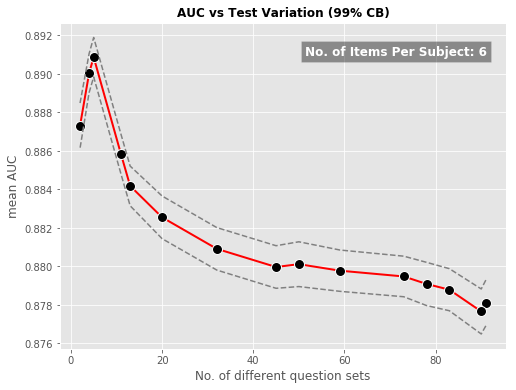

In [12]:
Perf23,Dperf23,Models23,Nitems23=getSystem(X,y,max_depth=2,n_estimators=3)
print(Nitems23)
PLOT(Dperf23,Nitems23,dn='23')

100%|██████████| 1000/1000 [00:01<00:00, 745.39it/s]


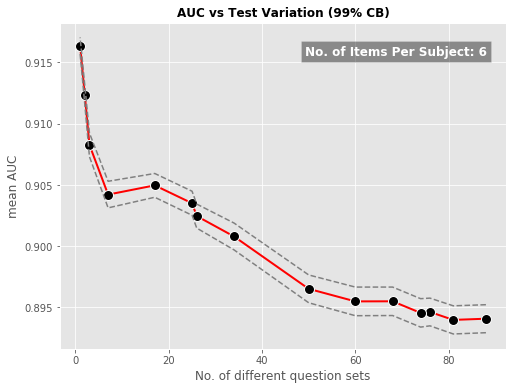

In [13]:
Perf32,Dperf32,Models32,Nitems32=getSystem(X,y,max_depth=3,n_estimators=2)
PLOT(Dperf32,Nitems32,dn='32')

In [16]:
pickleModel(Models23,threshold=.88,filename='model_2_3.pkl')
print("--")
pickleModel(Models32,threshold=.895,filename='model_3_2.pkl')

number of models (tests): 182
Number of items used:  128
Item Use Fraction: 0.7032967032967034
--
number of models (tests): 293
Number of items used:  192
Item Use Fraction: 0.6552901023890785


In [ ]:
drawTrees(loadModel('model_2_3.pkl'),1)

In [ ]:
FS23=getCoverage(load('model_2_3.pkl'))
FS32=getCoverage(load('model_3_2.pkl'))